In [1]:
%load_ext autoreload
%autoreload 2
import train_renderer
from Renderer.fast_stroke_gen import *
from Renderer.model import FCN
from train_renderer import get_criterion, get_renderer

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
import scipy.signal

In [2]:
device = torch.device("cuda")
batch_size = 64
gen = get_renderer("squareblur", batch_size).to(device)
criterion = get_criterion()

In [3]:
strokes = gen.generate_strokes().to(device)
target = gen(strokes)

In [12]:
num_plot = 5
rand_selection = np.random.randint(0, batch_size, (3*num_plot,))

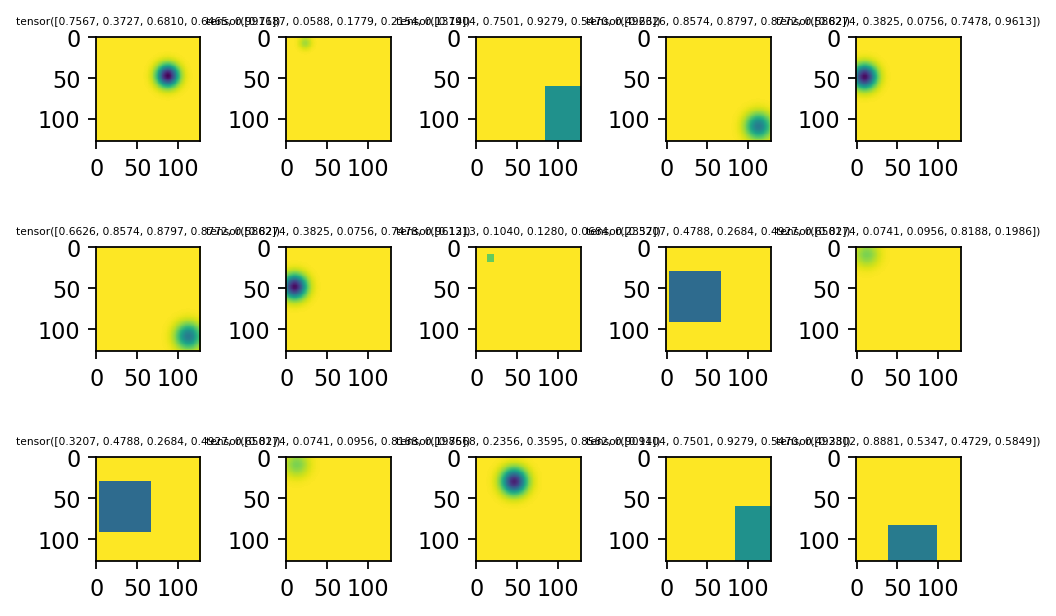

In [5]:
fig, axes = plt.subplots(3, num_plot, squeeze=False, dpi=160)
plt.rcParams.update({'font.size': 4})
plt.tight_layout()
for i, j in itertools.product(range(3), range(num_plot)):
    ax = axes[i, j]
    ax.set_title(str(strokes[rand_selection[i*3+j]].cpu()))
    im = ax.imshow(target[rand_selection[i*3+j]].cpu(), vmin=0, vmax=1)
#     plt.colorbar(im, ax=ax)
plt.show()

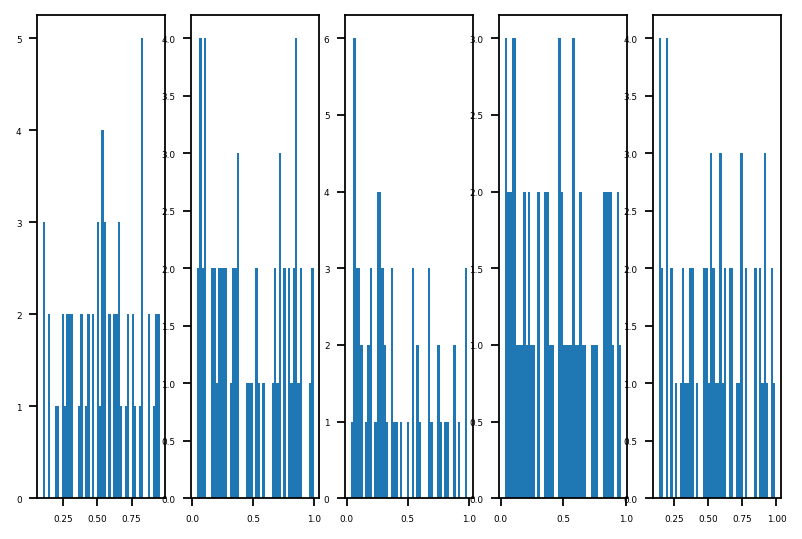

In [6]:
fig, axes = plt.subplots(1, gen.stroke_size(), dpi=160)
for i in range(gen.stroke_size()):
    data = strokes[:, i].cpu().numpy()
    ax = axes[i]
    ax.hist(data, bins=50)
plt.show()
    

In [7]:
def load_model(fpath):
    net = FCN(gen.stroke_size())
    train_renderer.load_weights(net, fpath)
    return net

def test_model(net, strokes, target):
    net.eval()
    with torch.no_grad():
        output = net(strokes)
        batch_size = output.shape[0]
        total_loss = criterion(output, target)
        losses = [criterion(output[i:i+1, ...], target[i:i+1, ...]) for i in range(batch_size)]
    return total_loss, losses, output

In [4]:
baseline = load_model('models_renderer/renderer.pkl').to(device)

In [10]:
test = load_model('models_renderer/squareblur_my_loss/model.pkl').to(device)

Total Loss:  tensor(0.0009, device='cuda:0')


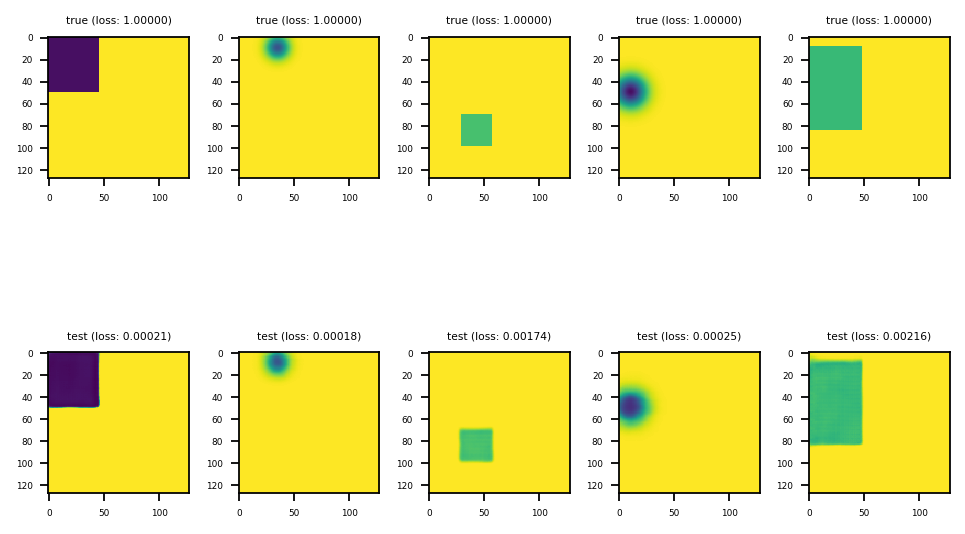

In [13]:
# baseline_acc, baseline_output = test_model(baseline, strokes, target)
total_loss, test_acc, test_output = test_model(test, strokes, target)
print("Total Loss: ", total_loss)
# print(test_acc[0].shape)
fig, axes = plt.subplots(2,num_plot, dpi=160)
plt.rcParams.update({'font.size': 4})
plt.tight_layout()
for i, j in itertools.product(range(2), range(num_plot)):
    if i == 0:
        acc = 1
        output = target
        name = "true"
#     elif i == 1:
#         acc = baseline_acc[j]
#         output = baseline_output
#         name = "baseline"
    elif i == 1:
        acc = test_acc[j].cpu().item()
        output = test_output
        name = "test"
    ax = axes[i, j]
    ax.set_title(f"{name} (loss: {acc:1.5f})")
    ax.imshow(output[rand_selection[j]].cpu(), vmin=0, vmax=1)
plt.show()
    

In [24]:
a = torch.arange(10).reshape(2,5)
(a > 5).shape

torch.Size([2, 5])